In [ ]:
!git clone https://github.com/tareknaous/readme.git

Cloning into 'readme'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 71 (delta 14), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (71/71), 1.96 MiB | 6.05 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from tqdm.notebook import tqdm

#from transformers import BertTokenizer
from transformers import XLMRobertaTokenizer
from torch.utils.data import TensorDataset

#from transformers import BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification
import pandas as pd
import numpy as np

In [ ]:
language = 'en'
data_train = pd.concat([pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_train.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_val.xlsx')], axis=0)
data_val = pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_test.xlsx')

In [ ]:
n_labels = len(np.unique(data_train['Rating']))
label_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

for label in np.unique(data_train['Rating']):
    label_dict[label] = label-1

In [ ]:
train = pd.DataFrame(columns=['text', 'label'])
train['text'] = data_train['Sentence']
train['label'] = data_train['Rating'].replace(label_dict)

val = pd.DataFrame(columns=['text', 'label'])
val['text'] = data_val['Sentence']
val['label'] = data_val['Rating'].replace(label_dict)

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    train['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pa

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base',
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 20

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr=1e-6,
                  eps=1e-8)

epochs = 100

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.6420923715501319
Validation loss: 1.5274641434351603
F1 Score (macro): 0.12892561983471076


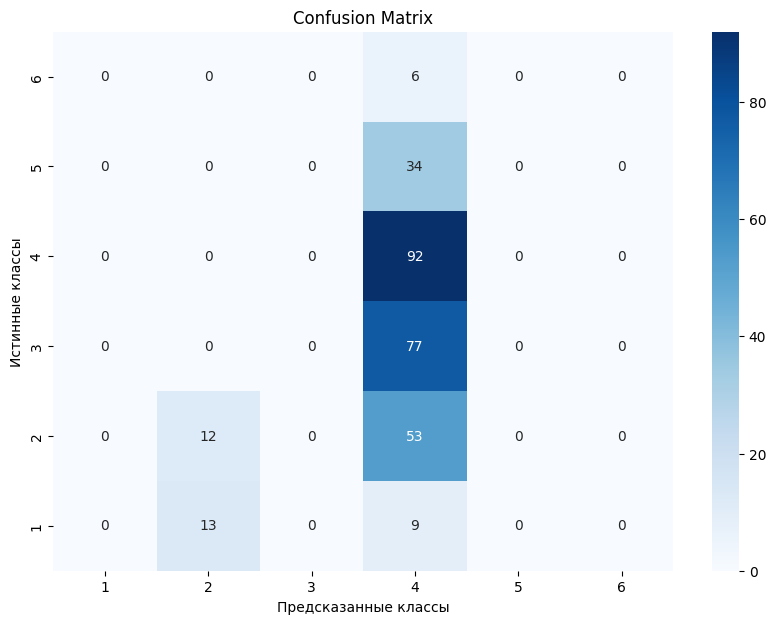

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 12/65 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.18
F1 Score: 0.27

Class: 3
Accuracy: 0/77 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 4
Accuracy: 92/92 (True Positives / Total Actual Positives)
Precision: 0.34
Recall: 1.00
F1 Score: 0.51

Class: 5
Accuracy: 0/34 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 2:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3956180257121409
Validation loss: 1.2519932587941487
F1 Score (macro): 0.24600853405938708


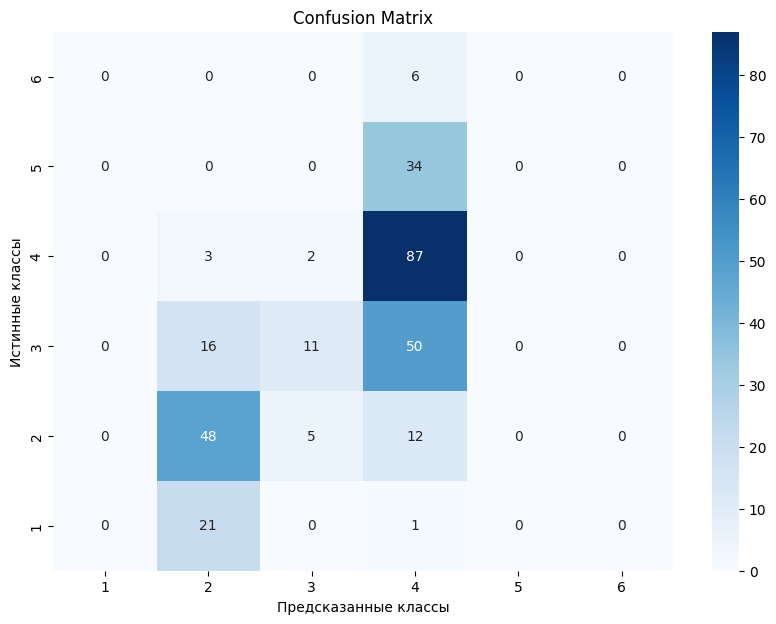

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 48/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.74
F1 Score: 0.63

Class: 3
Accuracy: 11/77 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.14
F1 Score: 0.23

Class: 4
Accuracy: 87/92 (True Positives / Total Actual Positives)
Precision: 0.46
Recall: 0.95
F1 Score: 0.62

Class: 5
Accuracy: 0/34 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 3:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.2080961667646573
Validation loss: 1.0443370819091797
F1 Score (macro): 0.3209108889025104


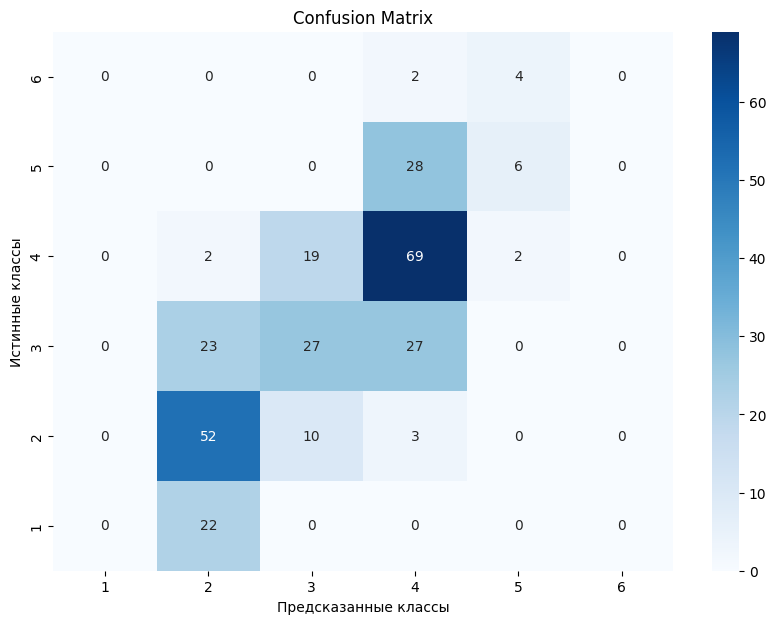

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 52/65 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.80
F1 Score: 0.63

Class: 3
Accuracy: 27/77 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.35
F1 Score: 0.41

Class: 4
Accuracy: 69/92 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.75
F1 Score: 0.62

Class: 5
Accuracy: 6/34 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.18
F1 Score: 0.26

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 4:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.0801020076894385
Validation loss: 1.0327876051266989
F1 Score (macro): 0.3134410100843391


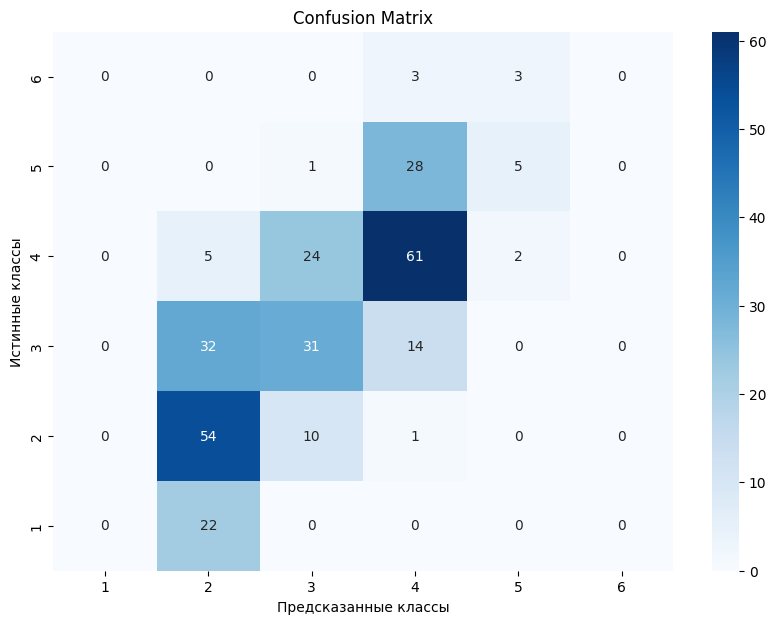

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 54/65 (True Positives / Total Actual Positives)
Precision: 0.48
Recall: 0.83
F1 Score: 0.61

Class: 3
Accuracy: 31/77 (True Positives / Total Actual Positives)
Precision: 0.47
Recall: 0.40
F1 Score: 0.43

Class: 4
Accuracy: 61/92 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.66
F1 Score: 0.61

Class: 5
Accuracy: 5/34 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.15
F1 Score: 0.23

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 5:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9918144087153157
Validation loss: 0.9640798727671306
F1 Score (macro): 0.3845423724633353


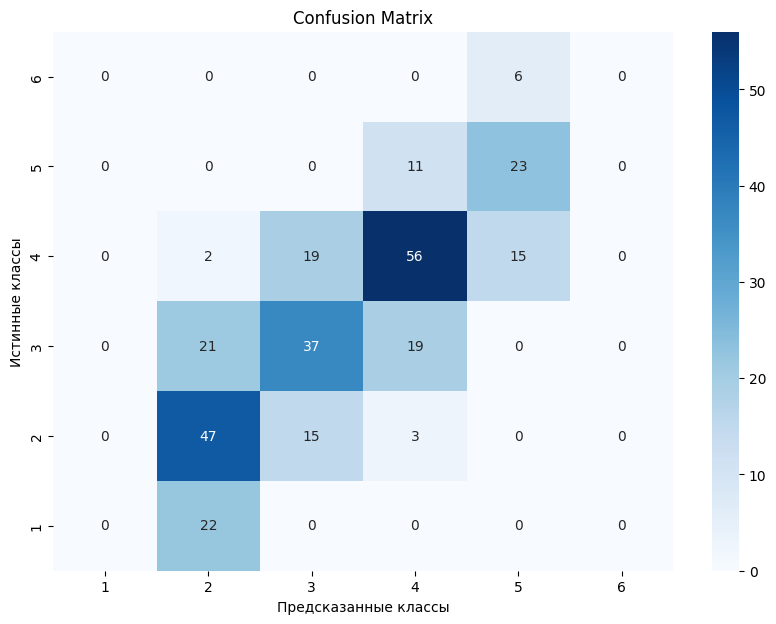

Class: 1
Accuracy: 0/22 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 47/65 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.72
F1 Score: 0.60

Class: 3
Accuracy: 37/77 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.48
F1 Score: 0.50

Class: 4
Accuracy: 56/92 (True Positives / Total Actual Positives)
Precision: 0.63
Recall: 0.61
F1 Score: 0.62

Class: 5
Accuracy: 23/34 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.68
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 6:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.9159918281975694
Validation loss: 0.9576674103736877
F1 Score (macro): 0.4882531660455023


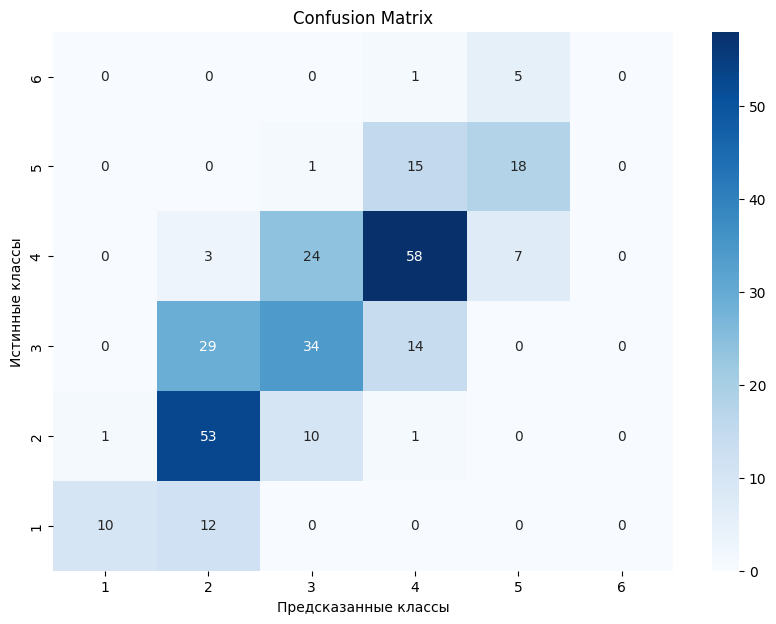

Class: 1
Accuracy: 10/22 (True Positives / Total Actual Positives)
Precision: 0.91
Recall: 0.45
F1 Score: 0.61

Class: 2
Accuracy: 53/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.82
F1 Score: 0.65

Class: 3
Accuracy: 34/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.44
F1 Score: 0.47

Class: 4
Accuracy: 58/92 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.63
F1 Score: 0.64

Class: 5
Accuracy: 18/34 (True Positives / Total Actual Positives)
Precision: 0.60
Recall: 0.53
F1 Score: 0.56

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 7:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.8466157429800258
Validation loss: 1.0174685875574747
F1 Score (macro): 0.5118424600093042


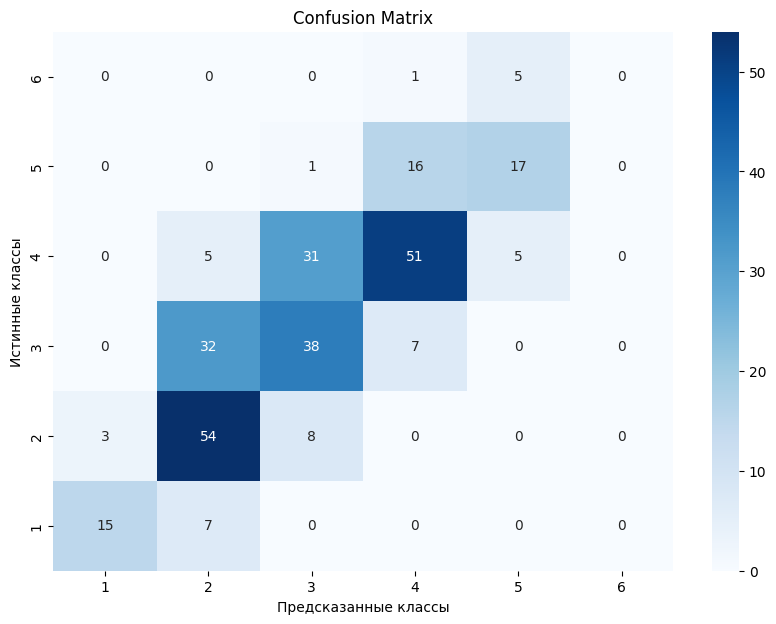

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.83
Recall: 0.68
F1 Score: 0.75

Class: 2
Accuracy: 54/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.83
F1 Score: 0.66

Class: 3
Accuracy: 38/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.49
F1 Score: 0.49

Class: 4
Accuracy: 51/92 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.55
F1 Score: 0.61

Class: 5
Accuracy: 17/34 (True Positives / Total Actual Positives)
Precision: 0.63
Recall: 0.50
F1 Score: 0.56

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 8:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.7872673909025868
Validation loss: 0.9732487042744954
F1 Score (macro): 0.5127034535625333


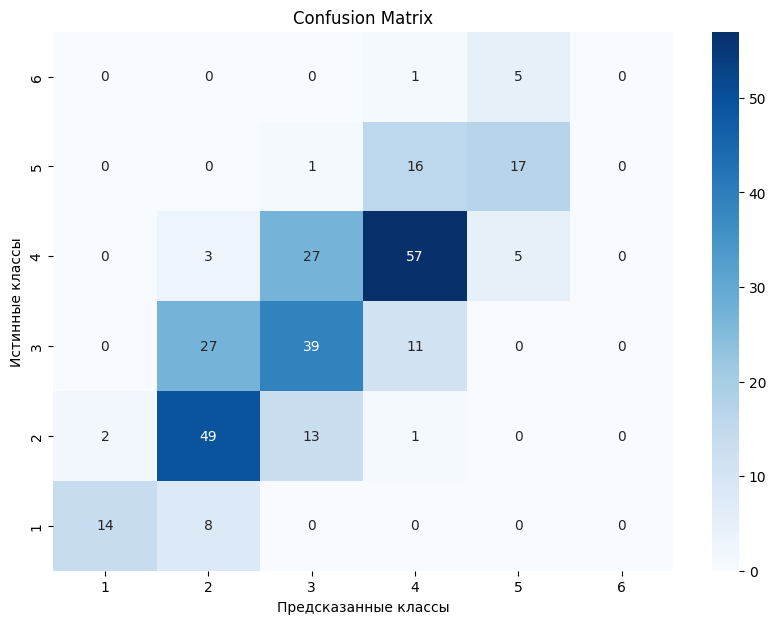

Class: 1
Accuracy: 14/22 (True Positives / Total Actual Positives)
Precision: 0.88
Recall: 0.64
F1 Score: 0.74

Class: 2
Accuracy: 49/65 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.75
F1 Score: 0.64

Class: 3
Accuracy: 39/77 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.51
F1 Score: 0.50

Class: 4
Accuracy: 57/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.62
F1 Score: 0.64

Class: 5
Accuracy: 17/34 (True Positives / Total Actual Positives)
Precision: 0.63
Recall: 0.50
F1 Score: 0.56

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 9:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.7219542879757919
Validation loss: 1.1683772206306458
F1 Score (macro): 0.45326843848063536


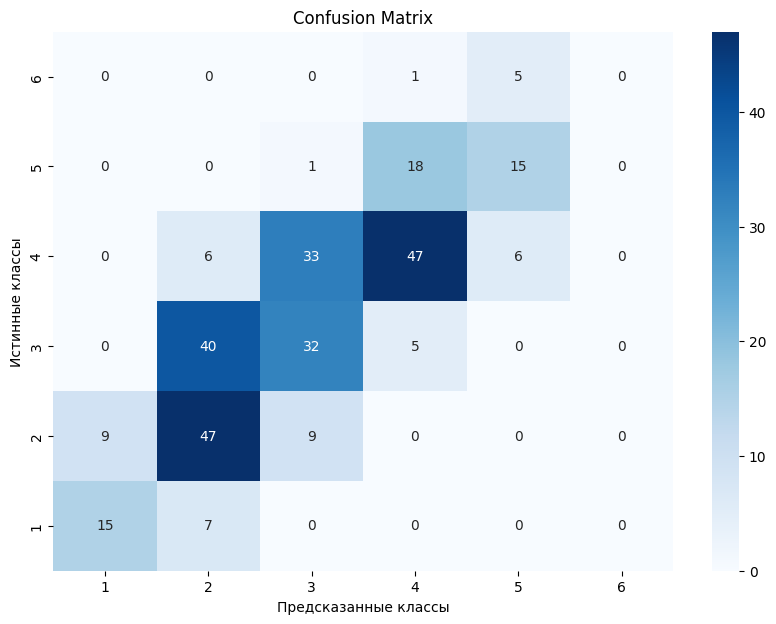

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.68
F1 Score: 0.65

Class: 2
Accuracy: 47/65 (True Positives / Total Actual Positives)
Precision: 0.47
Recall: 0.72
F1 Score: 0.57

Class: 3
Accuracy: 32/77 (True Positives / Total Actual Positives)
Precision: 0.43
Recall: 0.42
F1 Score: 0.42

Class: 4
Accuracy: 47/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.51
F1 Score: 0.58

Class: 5
Accuracy: 15/34 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.44
F1 Score: 0.50

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 10:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.649160639976892
Validation loss: 0.9971832474072774
F1 Score (macro): 0.5352602644648845


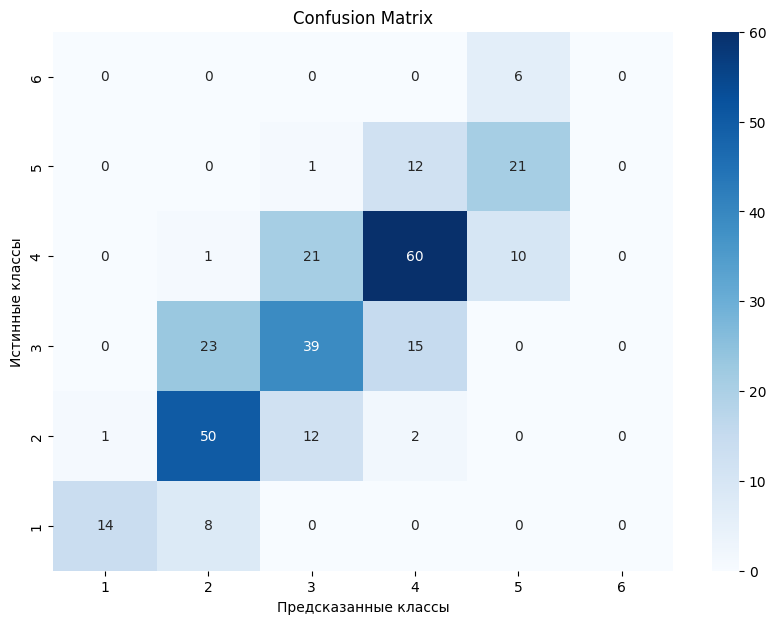

Class: 1
Accuracy: 14/22 (True Positives / Total Actual Positives)
Precision: 0.93
Recall: 0.64
F1 Score: 0.76

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.77
F1 Score: 0.68

Class: 3
Accuracy: 39/77 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.51
F1 Score: 0.52

Class: 4
Accuracy: 60/92 (True Positives / Total Actual Positives)
Precision: 0.67
Recall: 0.65
F1 Score: 0.66

Class: 5
Accuracy: 21/34 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.62
F1 Score: 0.59

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 11:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.603034523059064
Validation loss: 1.0997567415237426
F1 Score (macro): 0.512362592240641


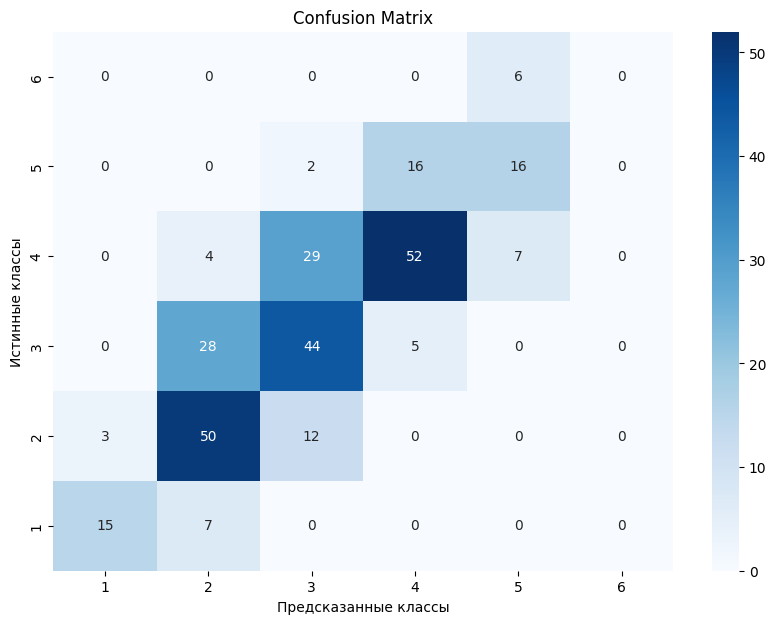

Class: 1
Accuracy: 15/22 (True Positives / Total Actual Positives)
Precision: 0.83
Recall: 0.68
F1 Score: 0.75

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.77
F1 Score: 0.65

Class: 3
Accuracy: 44/77 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.57
F1 Score: 0.54

Class: 4
Accuracy: 52/92 (True Positives / Total Actual Positives)
Precision: 0.71
Recall: 0.57
F1 Score: 0.63

Class: 5
Accuracy: 16/34 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.47
F1 Score: 0.51

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 12:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.5485529351656832
Validation loss: 1.1970045924186707
F1 Score (macro): 0.4634429277125665


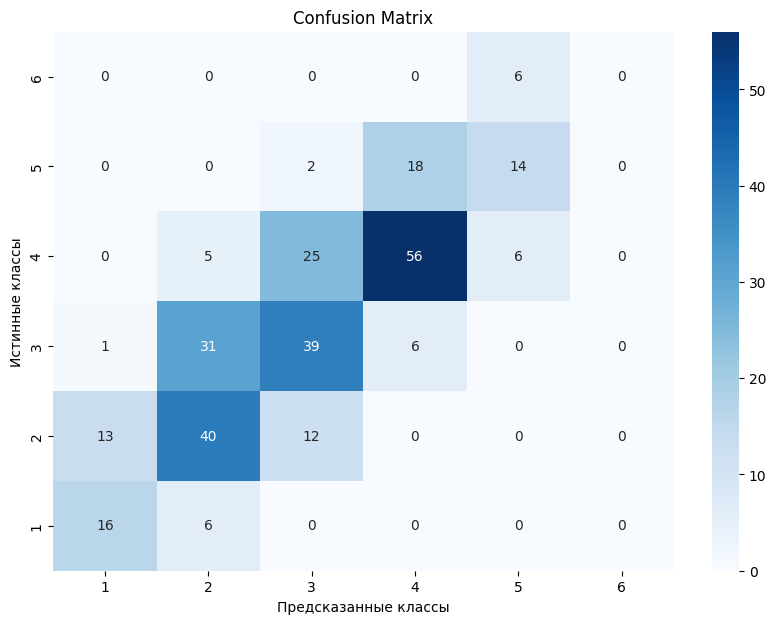

Class: 1
Accuracy: 16/22 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.73
F1 Score: 0.62

Class: 2
Accuracy: 40/65 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.62
F1 Score: 0.54

Class: 3
Accuracy: 39/77 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.51
F1 Score: 0.50

Class: 4
Accuracy: 56/92 (True Positives / Total Actual Positives)
Precision: 0.70
Recall: 0.61
F1 Score: 0.65

Class: 5
Accuracy: 14/34 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.41
F1 Score: 0.47

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 13:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.47614332939696125
Validation loss: 1.203975216547648
F1 Score (macro): 0.5733225709780804


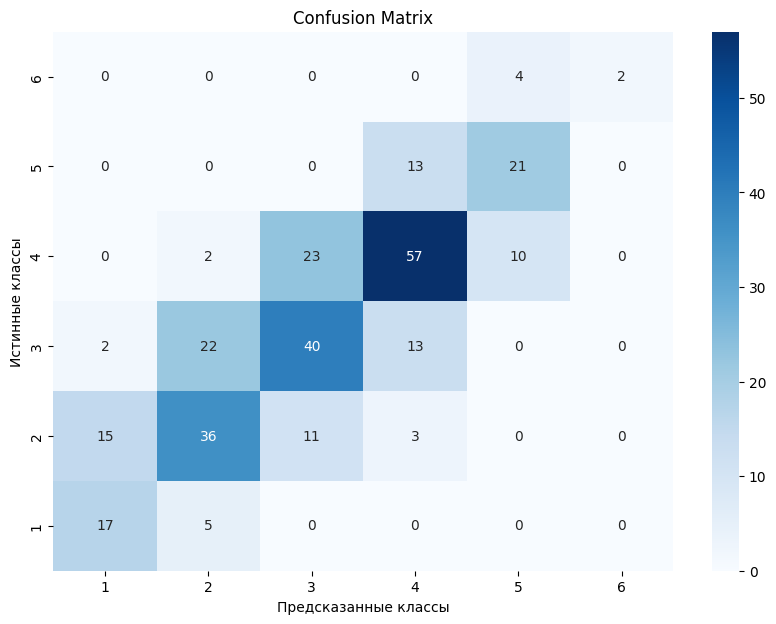

Class: 1
Accuracy: 17/22 (True Positives / Total Actual Positives)
Precision: 0.50
Recall: 0.77
F1 Score: 0.61

Class: 2
Accuracy: 36/65 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.55
F1 Score: 0.55

Class: 3
Accuracy: 40/77 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.52
F1 Score: 0.53

Class: 4
Accuracy: 57/92 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.62
F1 Score: 0.64

Class: 5
Accuracy: 21/34 (True Positives / Total Actual Positives)
Precision: 0.60
Recall: 0.62
F1 Score: 0.61

Class: 6
Accuracy: 2/6 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.33
F1 Score: 0.50



Epoch 14:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.43794843613162754
Validation loss: 1.2259386777877808
F1 Score (macro): 0.5959515960088054


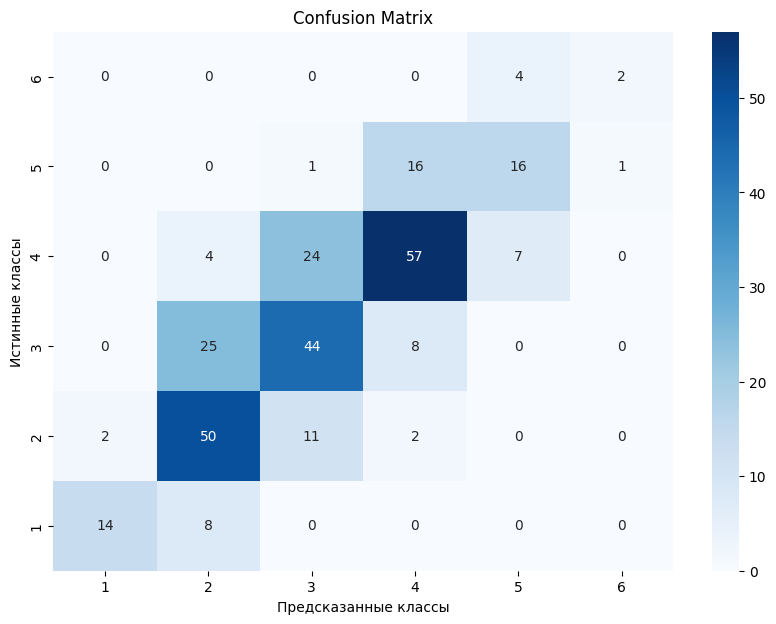

Class: 1
Accuracy: 14/22 (True Positives / Total Actual Positives)
Precision: 0.88
Recall: 0.64
F1 Score: 0.74

Class: 2
Accuracy: 50/65 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.77
F1 Score: 0.66

Class: 3
Accuracy: 44/77 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.57
F1 Score: 0.56

Class: 4
Accuracy: 57/92 (True Positives / Total Actual Positives)
Precision: 0.69
Recall: 0.62
F1 Score: 0.65

Class: 5
Accuracy: 16/34 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.47
F1 Score: 0.52

Class: 6
Accuracy: 2/6 (True Positives / Total Actual Positives)
Precision: 0.67
Recall: 0.33
F1 Score: 0.44



Epoch 15:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.3952435456861661
Validation loss: 1.2773666858673096
F1 Score (macro): 0.49741194663907035


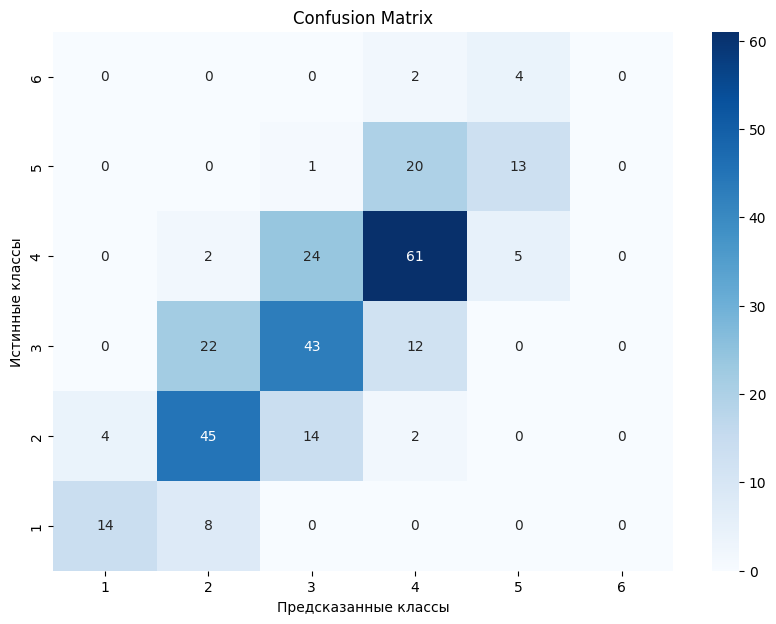

Class: 1
Accuracy: 14/22 (True Positives / Total Actual Positives)
Precision: 0.78
Recall: 0.64
F1 Score: 0.70

Class: 2
Accuracy: 45/65 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.69
F1 Score: 0.63

Class: 3
Accuracy: 43/77 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.56
F1 Score: 0.54

Class: 4
Accuracy: 61/92 (True Positives / Total Actual Positives)
Precision: 0.63
Recall: 0.66
F1 Score: 0.65

Class: 5
Accuracy: 13/34 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.38
F1 Score: 0.46

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 16:   0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = 'cuda'

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

min_loss = 10

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (macro): {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    plot_confusion_matrix(predictions, true_vals, label_dict)
    metrics_per_class(predictions, true_vals, label_dict)

    if val_f1 < min_loss:
        min_loss = val_loss
        model.save_pretrained(f"/content/ReadMe_{language}_roberta")